![Astrofisica Computacional](../../../logo.PNG)

---
## 03. Cross-validation of Decision Trees

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

IN this notebook we will introduce the cross-validation method to evaluate decision trees.

---

In previous lessons, we use the median of the residuals to evaluate the predictions of the model.  This is very basic method based on a split of the original dataset into train and test subsets, and is called **hold-out validation**. A disadvantage of this procedure is that the obtained precision depends on how the subsets are defined.

Now, we will introduce a better evaluation method called **k-fold cross-validation**. It is similar to the hold-out validation, but the original datasat will be splitted into k-subsets and the model will be trained k-times using different combinations of the subsets, calculating the precision each time (i.e. it will be calculated a hold-out validation k-times). 

During each iteration, we will use a different combination of k-1 subsets to train the algorithm and the remaining subset will be used to test the model. Then, we take the mean of the precision of the k-measurements to obtain a global precision for the model.

### The Dataset

Once again, we will use the file `'sdss_galaxy_colors.npy` but this time we will consider the feature 'spec_class'. This feature indicates if the sample corresponds to a Quasi-Stellar Objects (QSO) or to a normal  galaxy (GALAXY). As is well known,  QSOs are galaxies possesing an active nucleus (AGN) which implies a bigger bright and therefore a better detection with the SDSS instruments even for higher redshifts.


In [1]:
import numpy as np

data = np.load('sdss_galaxy_colors.npy')
data

array([(19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301  , 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703 , 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744 , 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796 , 16.19755, b'GALAXY', 0.0784592 , 2.159406e-05),
       (19.98672, 19.75385, 19.5713 , 19.27739, 19.25895, b'QSO', 1.567295  , 4.505933e-04),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264 , b'QSO', 0.4749449 , 6.203324e-05)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

The features in the data set are

| dtype | Feature|
|:-:|:-:|
|`u` |u band filter|
|`g` |g band filter|
|`r` |r band filter|
|`i` |i band filter|
|`z` |z band filter|
|`spec_class` |spectral class|
|`redshift` |redshift|
|`redshift_err` |redshift error|


In [2]:
n = data.size
n

50000

In [3]:
features = np.asarray([data['u']-data['g'],\
                       data['g']-data['i'],\
                       data['r']-data['i'],\
                       data['i']-data['z'] ])
features = features.T

targets = np.asarray(data['redshift'])
classes = np.array(data['spec_class'])

### K-Fold

In order to implement the k-fold cross validation, we will use the function [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to split the sets. The command to make the split is 

```
kf = KFold(n_splits=k, shuffle=True)
```

where `n_splits=k` defines the number of subsets and the argument `shuffle` has the default value 'False', but it is a good practice to activate in order to obtain a random distribution of elements in each subset (this distributiion prevents the apparition of a bias due to order of the samples in the datafile). 

In this example, we will use the function `KFold` with a value of **k=5** and the decision tree will have a depth of   `max_depth=19` (according to the previous discussion about over-fit).

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
d_tree = DecisionTreeRegressor(max_depth=19)

The method `KFold.split()` is applied to the set of features in order to generate the train and tests subsets. **Note that this method only defines the set of indices of each subset, but not the set itself**. Therefore, we need to use these indices to define the subsets to train and evaluate the predictions of the algorithm. In order to implement this procedure we use a `for` loop over the k-iterations.


In [5]:
# declare an array for predicted redshifts from each iteration
all_predictions = np.zeros_like(targets)

for train_indices, test_indices in kf.split(features):
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]
    
    # Train the decision tree
    d_tree.fit(train_features, train_targets)
    
    # Predict using the model
    predictions = d_tree.predict(test_features)
    
    # put the predicted values in the all_predictions array defined above
    all_predictions[test_indices] = predictions



# Evaluate the model using the median of differences of all_predictions
eval_d_tree = np.median(np.abs(all_predictions - targets))
eval_d_tree

0.018260268684077062

Now, we can visualize predictions vs targets to evaluate the model,

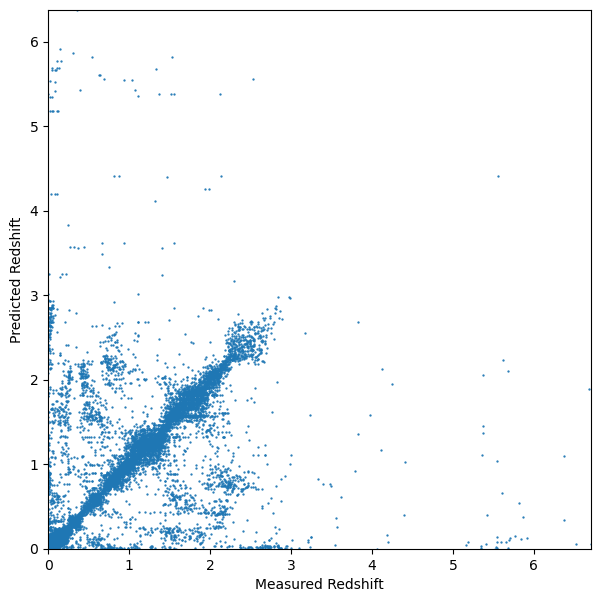

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot the results to see how well our model looks
plt.figure(figsize=(7,7))
plt.scatter(targets, all_predictions, s=0.4)
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.show()


Note that this plot shows that many of the predictions reproduce the targets but there are also many points out of the main trend (outliers).

---
### Spectral Class 

Now, we will incorporate the feature'spec_class' which, for each sample, may have one of the possible values b'GALAXY' and b'QSO'.

Using the variable array 'classes' defined above, we will filter the dataset to obtain a subset of objects with the class 'GALAXY' and a subset with the objects of the type 'QSO',

In [16]:
QSO_ids = np.where(classes == b'QSO')[0]
GALAXY_ids = np.where(classes == b'GALAXY')[0]


QSO_ids.shape, GALAXY_ids.shape

((8525,), (41475,))

In [17]:
classes

array([b'QSO', b'GALAXY', b'GALAXY', ..., b'GALAXY', b'QSO', b'QSO'],
      dtype='|S6')

Hence, we have 8525 QSO objects and 41475 GALAXY objects.

Now, we will evaluate the decision tree specifically for each type of objects:


In [18]:
all_predictions[QSO_ids]

array([1.57413203, 5.42518   , 2.043743  , ..., 1.06697121, 1.5568455 ,
       1.954737  ])

In [19]:
eval_QSO = np.median(np.abs(all_predictions[QSO_ids] - targets[QSO_ids]))
eval_GALAXY = np.median(np.abs(all_predictions[GALAXY_ids] - targets[GALAXY_ids]))


print('The median of the residues for each type of objects is:\n')
print('QSOs : ', eval_QSO)
print('GALAXYs : ', eval_GALAXY)

The median of the residues for each type of objects is:

QSOs :  0.08135584615384639
GALAXYs :  0.015298534758620683


Note that there is a better result for galaxies than for QSOs. The reason is simple: QSO are objects with a high redshift and therefore, they are more difficult to observe and the dispersion of results is higher (there are more outliers in the predictions vs. targets plot).

In order to illustrte the behavior of the model for each type of object we plot again predictions vs. targets indicating the class of the sample with colors:

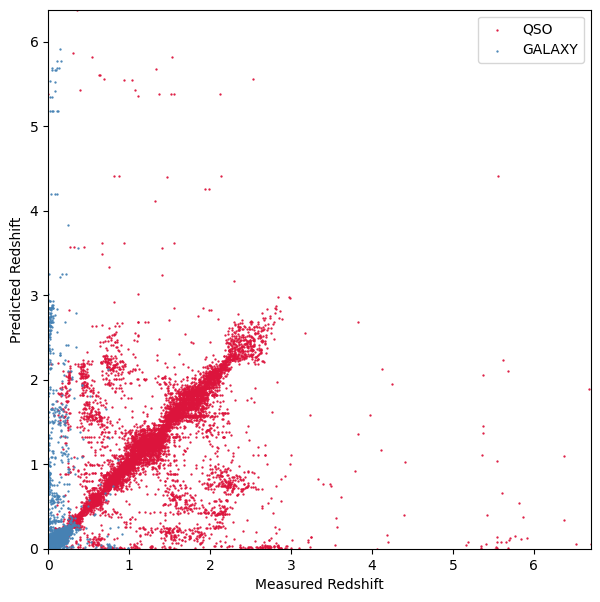

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot the results to see how well our model looks
plt.figure(figsize=(7,7))
plt.scatter(targets[QSO_ids], all_predictions[QSO_ids], s=0.4, color='crimson', label='QSO')
plt.scatter(targets[GALAXY_ids], all_predictions[GALAXY_ids], s=0.4, color='steelblue', label='GALAXY')
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.legend()
plt.show()